In [1]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
from tqdm import tqdm
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load Dataset

In [3]:
train_x = pd.read_csv('train_x_df.csv') 
train_y = pd.read_csv('train_y_df.csv')
test_x = pd.read_csv('test_x_df.csv') 
submission = pd.read_csv('sample_submission.csv') 

train_x.shape, train_y.shape, test_x.shape 


((10572180, 12), (919320, 12), (738300, 12))

In [4]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1] 
    time_size = len(df_2d.time.value_counts()) 
    sample_size = len(df_2d.sample_id.value_counts()) 
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size]) 
    return array_3d  

def plot_series(x_series, y_series, y_predicted): 
    plt.plot(x_series, label = 'input_series') 
    plt.plot(np.arange(len(x_series), len(x_series) + len(y_series)), y_series, label = 'actual_series') 
    plt.plot(np.arange(len(x_series), len(x_series) + len(y_predicted)), y_predicted, label = 'predicted_series') 
    plt.legend() 
    
def plot_predicted_series(x_series, y_predicted): 
    plt.plot(x_series, label = 'input_series') 
    plt.plot(np.arange(len(x_series), len(x_series) + len(y_predicted)), y_predicted, label = 'predicted_series') 
    plt.legend() 
    

In [5]:
x_train = df2d_to_array3d(train_x) 
y_train = df2d_to_array3d(train_y) 
x_test = df2d_to_array3d(test_x) 

x_train.shape, y_train.shape, x_test.shape

((7661, 1380, 10), (7661, 120, 10), (535, 1380, 10))

In [6]:
y_train_close = y_train[:,:,4]
x_train_close = x_train[:,:,4].reshape((-1,1380)) 
x_test_close = x_test[:,:,4].reshape((-1,1380))

close_prices = np.concatenate([x_train_close, y_train_close], axis = 1)
close_prices.shape 


(7661, 1500)

# Preprocess Data
Given time series data (t_1, t_2, ..., tN) predict t_{N+K} Here, we let K = 120 and N is a hyperparameter, but we can let it be 60 minutes.

In [7]:
K = 120 
N = 60 # get 60 minute data 
seq_len = 1500 
X = [] 
Y = [] 

for j in tqdm(range(close_prices.shape[0]), position = 0, leave = True):   
    i = 0
    while i+N+K < 1500: 
        X.append(close_prices[j, i:i+N]) 
        Y.append(close_prices[j, i+N+K]) 
        i += 1 

X = np.asarray(X) 
Y = np.asarray(Y) 

X.shape, Y.shape


100%|██████████| 7661/7661 [00:09<00:00, 804.54it/s]


((10112520, 60), (10112520,))

In [8]:
X = X.reshape((-1,N,1)) # (batch_size, timesteps, num_features)
X.shape

(10112520, 60, 1)

# Train Transformer

In [12]:
def transformer_block(inputs, node, drop_rate, activation): 
    attn_output = MultiHeadAttention(num_heads = 2, key_dim = node)(inputs, inputs) 
    attn_output = Dropout(drop_rate)(attn_output) 
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output) 
    ffn_output = Dense(node, activation = activation)(out1) 
    ffn_output = Dense(node)(ffn_output) 
    ffn_output = Dropout(drop_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output) 
    return out2
    
    
def build_transformer(node = 64, activation = 'relu', drop_rate = 0.2): 
    inputs = Input((N, 1))
    bn = BatchNormalization()(inputs)
    x = Conv1D(node*2, 5, activation = activation)(bn) 
    x = MaxPooling1D(3)(x) 
    x = Dropout(drop_rate)(x) 
    x = Conv1D(node, 5, activation = activation)(x) 
    x = MaxPooling1D(3)(x) 
    x = Dropout(drop_rate)(x) 
    
    positions = tf.range(start=0, limit=x.shape[1], delta=1)
    positions = Embedding(input_dim = x.shape[1], output_dim = node)(positions) 
    x = x + positions 
    
    x = transformer_block(x, node, drop_rate, activation)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(drop_rate)(x)
    x = Dense(1, activation = 'relu')(x) 
    model = Model(inputs=inputs,outputs=x) 
    model.compile(loss = 'mape', optimizer = 'adam', metrics=['mae','mse','mape']) 
    return model


In [13]:
model = build_transformer()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 60, 1)        4           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 56, 128)      768         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)  (None, 18, 128)      0           conv1d_2[0][0]                   
____________________________________________________________________________________________

In [14]:
model_path = 'Transformer_epoch_{epoch:03d}_val_{val_loss:.3f}.h5'
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5)
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10) 


history = model.fit(X, 
                    Y, 
                    batch_size = 64, ## avoid OOM 
                    epochs = 20, 
                    callbacks = [learning_rate_reduction, checkpoint], 
                    validation_split = 0.1)


Epoch 1/20
 27494/142208 [====>.........................] - ETA: 11:15 - loss: 1.1149 - mae: 0.0112 - mse: 3.1626e-04 - mape: 1.1149

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 85926/142208 [=================>............] - ETA: 5:30 - loss: 1.1158 - mae: 0.0112 - mse: 3.1789e-04 - mape: 1.1158

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



142208/142208 [==============================] - 890s 6ms/step - loss: 1.1155 - mae: 0.0112 - mse: 3.1785e-04 - mape: 1.1155 - val_loss: 1.2945 - val_mae: 0.0131 - val_mse: 5.1684e-04 - val_mape: 1.2945

Epoch 00002: val_loss did not improve from 1.15691
Epoch 3/20
 84961/142208 [================>.............] - ETA: 5:35 - loss: 1.1121 - mae: 0.0111 - mse: 3.1643e-04 - mape: 1.1121

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



142208/142208 [==============================] - 883s 6ms/step - loss: 1.1121 - mae: 0.0111 - mse: 3.1600e-04 - mape: 1.1121 - val_loss: 1.1981 - val_mae: 0.0120 - val_mse: 4.5758e-04 - val_mape: 1.1981

Epoch 00003: val_loss did not improve from 1.15691
Epoch 4/20
  6371/142208 [>.............................] - ETA: 13:11 - loss: 1.1051 - mae: 0.0111 - mse: 3.0955e-04 - mape: 1.1051

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



142208/142208 [==============================] - 884s 6ms/step - loss: 1.1097 - mae: 0.0111 - mse: 3.1401e-04 - mape: 1.1097 - val_loss: 1.2614 - val_mae: 0.0126 - val_mse: 5.1225e-04 - val_mape: 1.2614

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00004: val_loss did not improve from 1.15691
Epoch 5/20
142208/142208 [==============================] - 881s 6ms/step - loss: 1.0940 - mae: 0.0109 - mse: 3.0690e-04 - mape: 1.0940 - val_loss: 1.2597 - val_mae: 0.0126 - val_mse: 4.9699e-04 - val_mape: 1.2597

Epoch 00005: val_loss did not improve from 1.15691
Epoch 6/20
142208/142208 [==============================] - 885s 6ms/step - loss: 1.0937 - mae: 0.0109 - mse: 3.0519e-04 - mape: 1.0937 - val_loss: 1.2582 - val_mae: 0.0126 - val_mse: 4.8782e-04 - val_mape: 1.2582

Epoch 00006: val_loss did not improve from 1.15691
Epoch 7/20
142208/142208 [==============================] - 885s 6ms/step - loss: 1.0921 - mae: 0.0109 - mse: 3.0437e-04 - mape: 1.0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 32773/142208 [=====>........................] - ETA: 10:43 - loss: 1.0849 - mae: 0.0109 - mse: 3.0032e-04 - mape: 1.0849

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 99677/142208 [====================>.........] - ETA: 4:10 - loss: 1.0848 - mae: 0.0109 - mse: 3.0060e-04 - mape: 1.0848

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



142208/142208 [==============================] - 884s 6ms/step - loss: 1.0846 - mae: 0.0109 - mse: 3.0051e-04 - mape: 1.0846 - val_loss: 1.2277 - val_mae: 0.0123 - val_mse: 4.7952e-04 - val_mape: 1.2277

Epoch 00009: val_loss did not improve from 1.15691
Epoch 10/20
 26813/142208 [====>.........................] - ETA: 11:16 - loss: 1.0826 - mae: 0.0108 - mse: 3.0065e-04 - mape: 1.0826

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 98561/142208 [===================>..........] - ETA: 4:16 - loss: 1.0832 - mae: 0.0108 - mse: 3.0016e-04 - mape: 1.0832

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 27374/142208 [====>.........................] - ETA: 11:16 - loss: 1.0812 - mae: 0.0108 - mse: 2.9995e-04 - mape: 1.0812

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 95919/142208 [===================>..........] - ETA: 4:31 - loss: 1.0802 - mae: 0.0108 - mse: 2.9886e-04 - mape: 1.0802

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



142208/142208 [==============================] - 882s 6ms/step - loss: 1.0799 - mae: 0.0108 - mse: 2.9842e-04 - mape: 1.0799 - val_loss: 1.2406 - val_mae: 0.0124 - val_mse: 4.9584e-04 - val_mape: 1.2406

Epoch 00011: val_loss did not improve from 1.15691
Epoch 12/20
 26756/142208 [====>.........................] - ETA: 11:21 - loss: 1.0820 - mae: 0.0108 - mse: 2.9925e-04 - mape: 1.0820

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 40123/142208 [=======>......................] - ETA: 10:01 - loss: 1.0787 - mae: 0.0108 - mse: 2.9840e-04 - mape: 1.0787

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



101091/142208 [====================>.........] - ETA: 4:01 - loss: 1.0780 - mae: 0.0108 - mse: 2.9772e-04 - mape: 1.0780

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



142208/142208 [==============================] - 879s 6ms/step - loss: 1.0777 - mae: 0.0108 - mse: 2.9748e-04 - mape: 1.0777 - val_loss: 1.2082 - val_mae: 0.0121 - val_mse: 4.6400e-04 - val_mape: 1.2082

Epoch 00014: val_loss did not improve from 1.15691
Epoch 15/20
142208/142208 [==============================] - 865s 6ms/step - loss: 1.0776 - mae: 0.0108 - mse: 2.9703e-04 - mape: 1.0776 - val_loss: 1.2124 - val_mae: 0.0122 - val_mse: 4.6594e-04 - val_mape: 1.2124

Epoch 00015: val_loss did not improve from 1.15691
Epoch 16/20
 59640/142208 [===========>..................] - ETA: 7:59 - loss: 1.0760 - mae: 0.0108 - mse: 2.9663e-04 - mape: 1.0760

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



121436/142208 [========================>.....] - ETA: 2:00 - loss: 1.0761 - mae: 0.0108 - mse: 2.9636e-04 - mape: 1.0761

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 39965/142208 [=======>......................] - ETA: 9:47 - loss: 1.0767 - mae: 0.0108 - mse: 2.9677e-04 - mape: 1.0767

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



102191/142208 [====================>.........] - ETA: 3:50 - loss: 1.0763 - mae: 0.0108 - mse: 2.9679e-04 - mape: 1.0763

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



142208/142208 [==============================] - 869s 6ms/step - loss: 1.0762 - mae: 0.0108 - mse: 2.9662e-04 - mape: 1.0762 - val_loss: 1.2209 - val_mae: 0.0122 - val_mse: 4.7349e-04 - val_mape: 1.2209

Epoch 00017: val_loss did not improve from 1.15691
Epoch 18/20
 19946/142208 [===>..........................] - ETA: 11:43 - loss: 1.0738 - mae: 0.0107 - mse: 2.9538e-04 - mape: 1.0738

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 81950/142208 [================>.............] - ETA: 5:46 - loss: 1.0741 - mae: 0.0107 - mse: 2.9546e-04 - mape: 1.0741

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



142208/142208 [==============================] - 869s 6ms/step - loss: 1.0745 - mae: 0.0108 - mse: 2.9557e-04 - mape: 1.0745 - val_loss: 1.2213 - val_mae: 0.0123 - val_mse: 4.7380e-04 - val_mape: 1.2213

Epoch 00018: val_loss did not improve from 1.15691
Epoch 19/20
 15305/142208 [==>...........................] - ETA: 12:16 - loss: 1.0749 - mae: 0.0108 - mse: 2.9418e-04 - mape: 1.0749

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 89913/142208 [=================>............] - ETA: 5:01 - loss: 1.0753 - mae: 0.0108 - mse: 2.9491e-04 - mape: 1.0753

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



142208/142208 [==============================] - 878s 6ms/step - loss: 1.0755 - mae: 0.0108 - mse: 2.9532e-04 - mape: 1.0755 - val_loss: 1.2246 - val_mae: 0.0123 - val_mse: 4.7362e-04 - val_mape: 1.2246

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00019: val_loss did not improve from 1.15691
Epoch 20/20
 22810/142208 [===>..........................] - ETA: 11:30 - loss: 1.0740 - mae: 0.0108 - mse: 2.9349e-04 - mape: 1.0740

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 96538/142208 [===================>..........] - ETA: 4:24 - loss: 1.0743 - mae: 0.0108 - mse: 2.9444e-04 - mape: 1.0743

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Make Prediction

In [15]:
# load model with best validation mape 
best_model = load_model('Transformer_epoch_001_val_1.157.h5') 

In [16]:
X_test = [] 
for j in tqdm(range(x_test.shape[0]), position = 0, leave = True): 
    for i in range(seq_len-K-N-120, seq_len-K-N):
        X_test.append(x_test_close[j, i:i+N])  

X_test = np.asarray(X_test).reshape((-1,N,1))

100%|██████████| 535/535 [00:00<00:00, 15838.06it/s]


In [17]:
predicted = best_model.predict(X_test) 
predicted = predicted.reshape((-1,120)) 
predicted.shape 

(535, 120)

In [18]:
## create submission dataframe version 1 
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_close[i,-1] 
    cnt = 0 
    for j in range(120): 
        if predicted[i,j] >= buy_price:    
            cnt += 1 
    buy_quantity = cnt/120 
    buy_quantities.append(buy_quantity)
    
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times  
submission.to_csv('transformers_comparison_bq.csv',index=False) 

100%|██████████| 535/535 [00:00<00:00, 3887.36it/s]


In [19]:
## create submission dataframe version 2 
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_close[i,-1] 
    cnt = 0 
    for j in range(1, 120): 
        if j == 1: 
            returns = predicted[i,j] - buy_price 
        else: 
            returns = predicted[i,j] - predicted[i,j-1]
        if returns >= 0:    
            cnt += 1 
    buy_quantity = cnt/119 # there can be 119 returns only 
    buy_quantities.append(buy_quantity)
    
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times  
submission.to_csv('transformers_returns_bq.csv',index=False) 

100%|██████████| 535/535 [00:00<00:00, 3206.31it/s]


In [22]:
buy_price_bq = pd.read_csv('transformers_comparison_bq.csv') 
buy_price_bq

,sample_id,buy_quantity,sell_time
0,7661,0.183333,111
1,7662,0.733333,46
2,7663,0.000000,95
3,7664,0.958333,24
4,7665,0.000000,118
...,...,...,...
530,8191,0.958333,1
531,8192,0.191667,1
532,8193,0.008333,82
533,8194,0.616667,2


In [21]:
returns_bq = pd.read_csv('transformers_returns_bq.csv')
returns_bq

,sample_id,buy_quantity,sell_time
0,7661,0.554622,111
1,7662,0.487395,46
2,7663,0.554622,95
3,7664,0.453782,24
4,7665,0.579832,118
...,...,...,...
530,8191,0.470588,1
531,8192,0.504202,1
532,8193,0.621849,82
533,8194,0.428571,2


# Visualize

In [23]:
predicted_train = best_model.predict(X[:2400,])

In [24]:
predicted_train = predicted_train.reshape((-1,120)) 
predicted_train.shape

(20, 120)

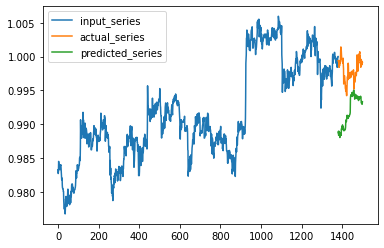

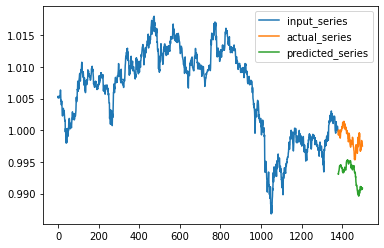

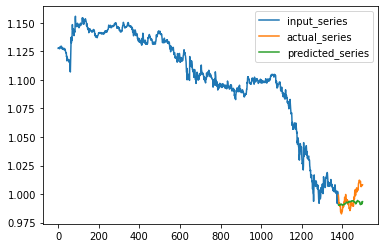

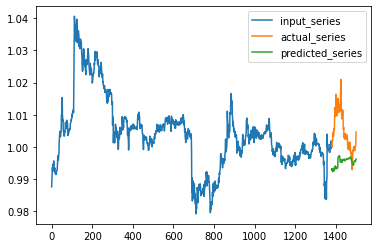

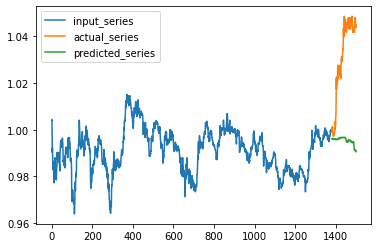

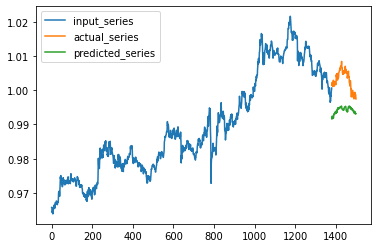

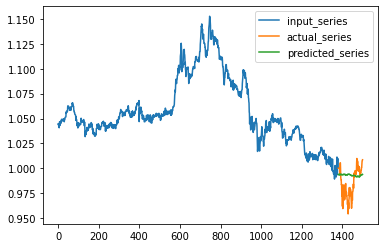

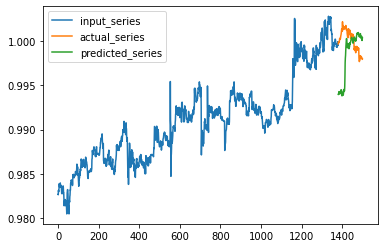

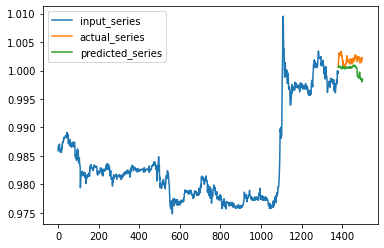

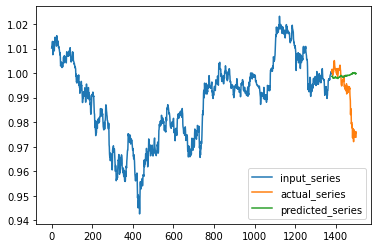

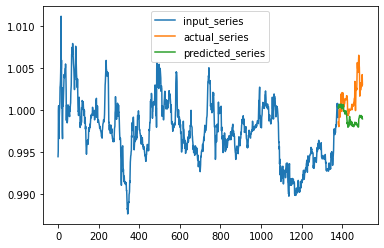

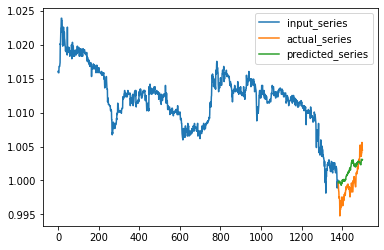

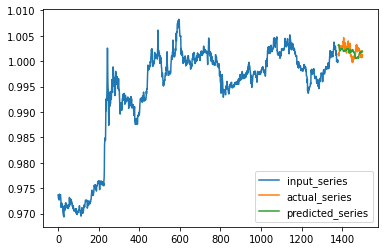

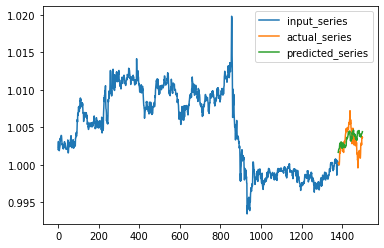

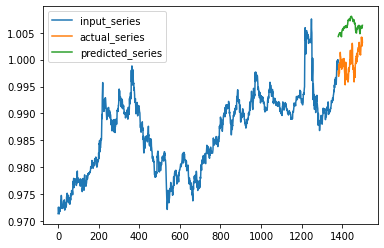

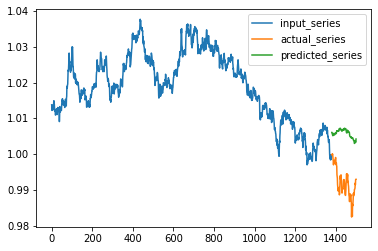

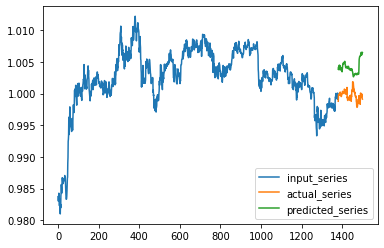

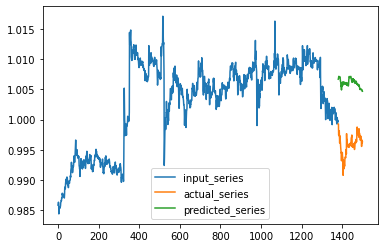

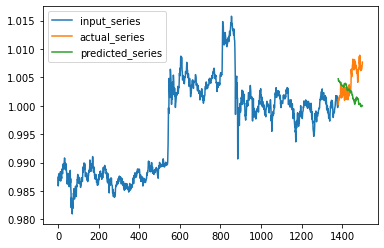

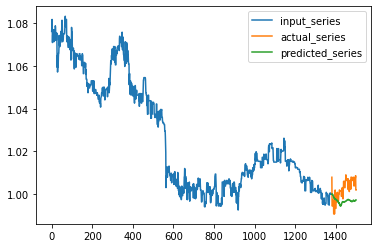

In [25]:
for i in range(20): 
    plt.plot() 
    plot_series(x_train_close[i,:], y_train_close[i,:], predicted_train[i,:])
    plt.show()